In [1]:
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data
import config
import network

In [2]:
scan_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/data.nii.gz')
mask_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/nodif_brain_mask.nii.gz')

In [3]:
mask_100206_long_pro = process_data.get_mask_pro(scan_100206, mask_100206)

In [4]:
normalized_scan_100206_full = np.load(config.norm_data_path + '/normalized_scan_100206_full.npy')

In [5]:
bvals_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvals')

In [52]:
rand_sub_bval_indice_100206 = np.array(process_data.get_rand_selected_bval_indice(bvals_all_100206, 13))

In [53]:
rand_sub_bval_indice_100206

array([ 16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  30,  31,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,
        58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
        71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180,
       181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193,
       194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206,
       207, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235,
       236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248,
       249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 26

In [54]:
bvals_100206_sub = bvals_all_100206[rand_sub_bval_indice_100206]*1e-3

In [55]:
normalized_scan_100206_sub = normalized_scan_100206_full[:, rand_sub_bval_indice_100206]

In [56]:
big_b_indice_100206_sub = np.where(bvals_100206_sub != 0.005)[0]

In [57]:
bvals_100206_sub_no_b5 = bvals_100206_sub[big_b_indice_100206_sub]

In [58]:
normalized_scan_100206_sub_no_b5 = normalized_scan_100206_sub[:, big_b_indice_100206_sub]

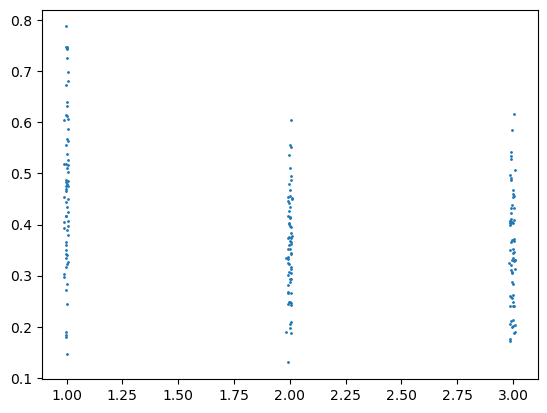

In [59]:
plt.plot(bvals_100206_sub_no_b5, normalized_scan_100206_sub_no_b5[42,:], "o", markersize = 1)

ANN

In [14]:
def squash(param, p_min, p_max):
    squashed_param_tensor =torch.clamp(param, min=p_min, max=p_max)
    unsqueezed_param = squashed_param_tensor.unsqueeze(1)
    return unsqueezed_param

In [50]:
def unitsphere2cart(theta, phi, X):
    mu_cart = torch.zeros(3,X.size()[0])
    sintheta = torch.sin(theta)
    mu_cart[0,:] = torch.squeeze(sintheta * torch.cos(phi))
    mu_cart[1,:] = torch.squeeze(sintheta * torch.sin(phi))
    mu_cart[2,:] = torch.squeeze(torch.cos(theta))
    return mu_cart

In [51]:
class BallStickNet(nn.Module):
    
    def __init__(self, gradient_directions, b_values):
        super(BallStickNet, self).__init__()
        self.gradient_directions = gradient_directions
        self.b_values = b_values
        self.fc_layers = nn.ModuleList()
        for i in range(3): 
            self.fc_layers.extend([nn.Linear(len(b_values), len(b_values)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values), 5))
        # if args.dropout != 0:
        #     self.dropout = nn.Dropout(args.dropout)
            
    def forward(self, X):
        # if args.dropout != 0:
        #     X = self.dropout(X)
        params = torch.abs(self.encoder(X))
        theta_uns = params[:, 0]
        theta = theta_uns.unsqueeze(1)
        phi_uns = params[:, 1]
        phi = phi_uns.unsqueeze(1)
        mu_cart = unitsphere2cart(theta, phi, X)
        mm_prod =  torch.einsum("ij,jk->ki",self.gradient_directions, mu_cart)
        lambda_par_uns = params[:, 2]
        lambda_par = squash(lambda_par_uns, 0.1, 3.0)
        lambda_iso_uns = params[:, 3]
        lambda_iso = squash(lambda_iso_uns, 0.1, 3.0)
        volume_0_uns = params[:, 4]
        volume_0 = squash(volume_0_uns, 0.01, 0.99)
        volume_1 = 1-volume_0
        X = volume_0 * torch.exp(-self.b_values * lambda_par * mm_prod ** 2) + volume_1 * torch.exp(-self.b_values * lambda_iso)
        return X, theta, phi, mu_cart, lambda_par, lambda_iso, volume_0, volume_1

In [60]:
n_100206_all = np.loadtxt(config.data_folder2 + '/100206/bvecs')

In [61]:
n_100206_sub = n_100206_all[:, rand_sub_bval_indice_100206]
n_100206_sub_no_b5 = n_100206_sub[:,big_b_indice_100206_sub].T
print(n_100206_sub_no_b5.shape)

b_values_100206_sub_no_b5 = torch.FloatTensor(bvals_100206_sub_no_b5)
gradient_directions_100206_sub_no_b5 = torch.FloatTensor(n_100206_sub_no_b5)

(195, 3)


In [62]:
net = network.BallStickNet(gradient_directions_100206_sub_no_b5, b_values_100206_sub_no_b5)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00001)

In [63]:
batch_size = 128
num_batches = len(normalized_scan_100206_sub_no_b5) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_100206_sub_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [65]:
loss_list=[]
avg_loss_list=[]

counter = 0

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 10

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, theta, phi, mu_cart_pred, lambda_par_pred, lambda_iso_pred, volume_0_pred, volume_1_pred = net(X_batch)
        if i == 100 and counter == 10:
            print("X_batch: ")
            print(X_batch.shape)
            print(X_batch)
            print("X_pred: ")
            print(X_pred.shape)
            print(X_pred)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_list.append(running_loss)
    avg_loss_list.append(running_loss/num_batches)
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/num_batches))
    

    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1

print("Done") 
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:00<00:00, 120.37it/s]


Loss: 436.2904106504284
Average Loss: 0.05970038459912813
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 128.27it/s]


Loss: 436.1772515838966
Average Loss: 0.05968490032620369
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 130.53it/s]


Loss: 435.74499926902354
Average Loss: 0.05962575249986638
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 127.01it/s]


Loss: 435.56933134328574
Average Loss: 0.05960171474319728
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 127.91it/s]


Loss: 434.73494451958686
Average Loss: 0.059487540300983424
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 122.38it/s]


Loss: 434.9073156588711
Average Loss: 0.05951112693744815
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 126.68it/s]


Loss: 434.59528120141476
Average Loss: 0.05946842928317115
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 130.51it/s]


Loss: 432.228978050407
Average Loss: 0.05914463301182362
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 122.59it/s]


Loss: 418.9717681868933
Average Loss: 0.057330564886000725
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:02<00:00, 117.60it/s]


Loss: 413.7638213997707
Average Loss: 0.05661792848929539
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


  2%|██▌                                                                                                                                                            | 115/7308 [00:03<01:12, 99.54it/s]

X_batch: 
torch.Size([128, 195])
tensor([[0.1011, 0.0346, 0.0404,  ..., 0.0698, 0.0379, 0.0573],
        [0.4589, 0.2683, 0.3805,  ..., 0.3103, 0.3295, 0.3707],
        [0.4716, 0.3037, 0.1989,  ..., 0.5141, 0.2437, 0.2107],
        ...,
        [0.3330, 0.1963, 0.1931,  ..., 0.3422, 0.1658, 0.2109],
        [0.4862, 0.1969, 0.1172,  ..., 0.4141, 0.2585, 0.2916],
        [0.0670, 0.0716, 0.0903,  ..., 0.0813, 0.0707, 0.0933]])
X_pred: 
torch.Size([128, 195])
tensor([[0.1004, 0.0528, 0.0520,  ..., 0.0982, 0.0538, 0.0522],
        [0.4835, 0.2571, 0.3295,  ..., 0.4309, 0.3307, 0.3386],
        [0.5075, 0.3189, 0.2510,  ..., 0.5108, 0.3056, 0.2414],
        ...,
        [0.4310, 0.2111, 0.1537,  ..., 0.4161, 0.2301, 0.1594],
        [0.4127, 0.2423, 0.1873,  ..., 0.3964, 0.2463, 0.2094],
        [0.1081, 0.0599, 0.0595,  ..., 0.1053, 0.0616, 0.0602]],
       grad_fn=<AddBackward0>)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:02<00:00, 117.10it/s]


Loss: 412.3285046382807
Average Loss: 0.05642152499155456
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:05<00:00, 111.25it/s]


Loss: 411.5128999121953
Average Loss: 0.05630992062290576
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 153.23it/s]


Loss: 410.6751085475553
Average Loss: 0.05619528031575743
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:08<00:00, 106.48it/s]


Loss: 410.22615751996636
Average Loss: 0.056133847498627036
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 166.08it/s]


Loss: 409.5702043257188
Average Loss: 0.056044089261866284
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.92it/s]


Loss: 409.49117846996523
Average Loss: 0.0560332756527046
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 187.32it/s]


Loss: 409.2994776738342
Average Loss: 0.056007044016671344
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.50it/s]


Loss: 408.75228844210505
Average Loss: 0.05593216864287152
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 181.62it/s]


Loss: 408.3745250159409
Average Loss: 0.055880476876839204
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.94it/s]


Loss: 408.35522993071936
Average Loss: 0.055877836607925474
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 162.99it/s]


Loss: 407.95104304817505
Average Loss: 0.055822529152733315
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 149.40it/s]


Loss: 407.9992800473701
Average Loss: 0.055829129727335815
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 134.14it/s]


Loss: 407.2875019083731
Average Loss: 0.05573173260924645
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:05<00:00, 112.01it/s]


Loss: 407.624458987033
Average Loss: 0.05577784058388519
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 179.51it/s]


Loss: 407.6927466671914
Average Loss: 0.05578718482036007
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 133.98it/s]


Loss: 407.1900325072929
Average Loss: 0.05571839525277681
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 177.93it/s]


Loss: 406.86975006060675
Average Loss: 0.05567456897381045
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 178.67it/s]


Loss: 406.72828587843105
Average Loss: 0.05565521153235236
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:02<00:00, 116.86it/s]


Loss: 406.5425263729412
Average Loss: 0.0556297928808075
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 129.82it/s]


Loss: 406.450258663157
Average Loss: 0.05561716730475602
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.85it/s]


Loss: 406.3014210369438
Average Loss: 0.05559680090817512
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 132.88it/s]


Loss: 405.6888306327164
Average Loss: 0.055512976277054794
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.66it/s]


Loss: 406.16306241299026
Average Loss: 0.055577868419949404
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 183.82it/s]


Loss: 405.94974110554904
Average Loss: 0.055548678312198826
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 184.53it/s]


Loss: 405.833360101562
Average Loss: 0.05553275316113328
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 161.72it/s]


Loss: 405.617390550673
Average Loss: 0.055503200677431995
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 129.17it/s]


Loss: 405.82359625422396
Average Loss: 0.05553141711196277
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 154.70it/s]


Loss: 405.4182424885221
Average Loss: 0.05547594998474577
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 165.91it/s]


Loss: 405.52228062064387
Average Loss: 0.055490186182354115
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 178.29it/s]


Loss: 405.3281747614965
Average Loss: 0.055463625446291256
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 165.54it/s]


Loss: 405.00119742564857
Average Loss: 0.055418883063170304
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.65it/s]


Loss: 405.1680982396938
Average Loss: 0.0554417211603303
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.35it/s]


Loss: 405.14803774817847
Average Loss: 0.05543897615601785
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 177.94it/s]


Loss: 405.03227918059565
Average Loss: 0.05542313617687406
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 192.87it/s]


Loss: 404.86665690131485
Average Loss: 0.05540047302973657
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.16it/s]


Loss: 404.65135804447345
Average Loss: 0.05537101232135652
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.61it/s]


Loss: 404.3355045290664
Average Loss: 0.055327792081153036
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 160.75it/s]


Loss: 404.7961145534646
Average Loss: 0.055390820272778404
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 147.92it/s]


Loss: 404.6124288237188
Average Loss: 0.055365685389124085
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.15it/s]


Loss: 404.466207196936
Average Loss: 0.05534567695634045
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 186.60it/s]


Loss: 403.99734825477935
Average Loss: 0.05528152001296926
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 187.71it/s]


Loss: 404.4974287250079
Average Loss: 0.055349949196087565
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.52it/s]


Loss: 404.5466195535846
Average Loss: 0.05535668028921519
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 178.11it/s]


Loss: 404.37456471449696
Average Loss: 0.05533313693411288
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 131.42it/s]


Loss: 404.17911954503506
Average Loss: 0.055306392931723465
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 165.15it/s]


Loss: 404.1854251269251
Average Loss: 0.055307255764494405
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 192.42it/s]


Loss: 404.20510213286616
Average Loss: 0.05530994829404299
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 183.43it/s]


Loss: 404.1730368833523
Average Loss: 0.055305560602538634
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 180.19it/s]


Loss: 404.11654048250057
Average Loss: 0.05529782984161201
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 156.69it/s]


Loss: 403.93659741966985
Average Loss: 0.05527320709081415
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 149.91it/s]


Loss: 404.04386149533093
Average Loss: 0.055287884714741505
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.15it/s]


Loss: 403.6571569493972
Average Loss: 0.05523496947857104
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 178.98it/s]


Loss: 403.9900476404
Average Loss: 0.05528052102359059
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.29it/s]


Loss: 403.8786400654353
Average Loss: 0.05526527641836827
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.84it/s]


Loss: 403.63225250924006
Average Loss: 0.05523156164603723
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 186.82it/s]


Loss: 403.4180315602571
Average Loss: 0.055202248434627406
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.98it/s]


Loss: 403.5863587560598
Average Loss: 0.055225281712651855
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 197.14it/s]


Loss: 403.3249676132109
Average Loss: 0.055189513904380254
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.44it/s]


Loss: 403.7601875059772
Average Loss: 0.05524906780322622
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.37it/s]


Loss: 403.76348936976865
Average Loss: 0.055249519618194944
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 140.01it/s]


Loss: 403.71370535180904
Average Loss: 0.055242707355201016
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.28it/s]


Loss: 403.769909480121
Average Loss: 0.05525039812262192
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.88it/s]


Loss: 403.00211671506986
Average Loss: 0.05514533616790775
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 148.30it/s]


Loss: 403.0423393177334
Average Loss: 0.055150840081791656
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 147.41it/s]


Loss: 403.3915863656439
Average Loss: 0.055198629770887235
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.19it/s]


Loss: 402.86860186676495
Average Loss: 0.05512706648423166
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.62it/s]


Loss: 403.44394048908725
Average Loss: 0.05520579371771856
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 179.36it/s]


Loss: 403.4009210164659
Average Loss: 0.055199907090375734
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 160.77it/s]


Loss: 403.31848175800405
Average Loss: 0.05518862640366777
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 157.76it/s]


Loss: 403.0774095803499
Average Loss: 0.05515563896830185
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 162.63it/s]


Loss: 402.6955546368845
Average Loss: 0.055103387334001705
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 180.53it/s]


Loss: 403.37506727548316
Average Loss: 0.05519636935898784
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 155.02it/s]


Loss: 403.1226201360114
Average Loss: 0.0551618254154367
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 142.17it/s]


Loss: 402.7803280367516
Average Loss: 0.05511498741608533
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 123.23it/s]


Loss: 402.9397230737377
Average Loss: 0.05513679845015568
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.73it/s]


Loss: 402.9426965364255
Average Loss: 0.055137205327918104
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 175.62it/s]


Loss: 402.776814899873
Average Loss: 0.055114506691279826
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 192.41it/s]


Loss: 402.9541021587793
Average Loss: 0.055138766031578995
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.05it/s]


Loss: 402.80960460938513
Average Loss: 0.055118993515241535
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 182.60it/s]


Loss: 402.84338223654777
Average Loss: 0.055123615522242445
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.18it/s]


Loss: 402.5412906287238
Average Loss: 0.05508227841115542
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 197.33it/s]


Loss: 402.8076977371238
Average Loss: 0.05511873258581333
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 202.79it/s]


Loss: 402.6114748357795
Average Loss: 0.05509188216143671
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.61it/s]


Loss: 402.809443612583
Average Loss: 0.05511897148502778
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.88it/s]


Loss: 402.4888888616115
Average Loss: 0.055075107944938625
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.34it/s]


Loss: 402.69591444637626
Average Loss: 0.055103436569017006
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.80it/s]


Loss: 402.67970457696356
Average Loss: 0.05510121846975418
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.61it/s]


Loss: 402.6139631846454
Average Loss: 0.05509222265799745
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.37it/s]


Loss: 402.5653942229692
Average Loss: 0.05508557665886278
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.27it/s]


Loss: 402.69962237006985
Average Loss: 0.05510394394773807
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.48it/s]


Loss: 402.39620632724836
Average Loss: 0.05506242560580848
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 197.93it/s]


Loss: 402.7130974784959
Average Loss: 0.0551057878323065
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.30it/s]


Loss: 402.4471597804222
Average Loss: 0.05506939789004135
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.29it/s]


Loss: 403.2040682665538
Average Loss: 0.055172970479824
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.73it/s]


Loss: 403.6951324811671
Average Loss: 0.05524016591148975
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.73it/s]


Loss: 403.5534400593024
Average Loss: 0.055220777238547125
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 140.37it/s]


Loss: 402.6165059583727
Average Loss: 0.055092570601857245
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 142.74it/s]


Loss: 402.7272706013173
Average Loss: 0.055107727230612656
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 192.06it/s]


Loss: 402.82159287459217
Average Loss: 0.05512063394562017
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 184.85it/s]


Loss: 402.56451506284066
Average Loss: 0.055085456357805235
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 202.08it/s]


Loss: 402.3838966805488
Average Loss: 0.05506074119876146
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 202.74it/s]


Loss: 402.7976542247925
Average Loss: 0.05511735826830767
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 174.06it/s]


Loss: 402.67811079486273
Average Loss: 0.0551010003824388
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 165.07it/s]


Loss: 402.71069813659415
Average Loss: 0.0551054595151333
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.95it/s]


Loss: 402.6742829452269
Average Loss: 0.055100476593490266
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 155.87it/s]


Loss: 402.19133195863105
Average Loss: 0.0550343913462823
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.76it/s]


Loss: 402.60700406716205
Average Loss: 0.055091270397805425
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.64it/s]


Loss: 402.6624102552887
Average Loss: 0.05509885197800885
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.09it/s]


Loss: 402.0223427671008
Average Loss: 0.05501126748318292
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 183.41it/s]


Loss: 402.4056273596361
Average Loss: 0.05506371474543461
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:03<00:00, 114.28it/s]


Loss: 402.258370464202
Average Loss: 0.05504356465027395
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 133.45it/s]


Loss: 402.6949251778424
Average Loss: 0.05510330120112786
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 148.59it/s]


Loss: 402.6377954175696
Average Loss: 0.05509548377361379
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.99it/s]


Loss: 402.1995512507856
Average Loss: 0.0550355160441688
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.48it/s]


Loss: 402.39089366351254
Average Loss: 0.05506169864032739
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 185.13it/s]


Loss: 402.3567136058118
Average Loss: 0.05505702156620304
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.36it/s]


Loss: 402.52385962498374
Average Loss: 0.05507989321633604
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.87it/s]


Loss: 402.010455498239
Average Loss: 0.055009640872774906
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.79it/s]


Loss: 402.5561509511899
Average Loss: 0.055084311843348374
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 185.26it/s]


Loss: 402.5257669466082
Average Loss: 0.05508015420725345
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 162.77it/s]


Loss: 402.43553775153123
Average Loss: 0.05506780757410115
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:01<00:00, 118.91it/s]


Loss: 402.46343069546856
Average Loss: 0.05507162434256548
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 125.57it/s]


Loss: 402.50593787408434
Average Loss: 0.05507744086946967
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 124.70it/s]


Loss: 402.38211339199916
Average Loss: 0.055060497180076516
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 125.87it/s]


Loss: 402.54012686386704
Average Loss: 0.055082119165827455
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 127.96it/s]


Loss: 402.0468748351559
Average Loss: 0.05501462436167979
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 136.12it/s]


Loss: 402.4776346278377
Average Loss: 0.055073567956737506
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 147.09it/s]

Loss: 402.11730607948266
Average Loss: 0.05502426191563802
Done, best loss: 402.010455498239
Done


<All keys matched successfully>

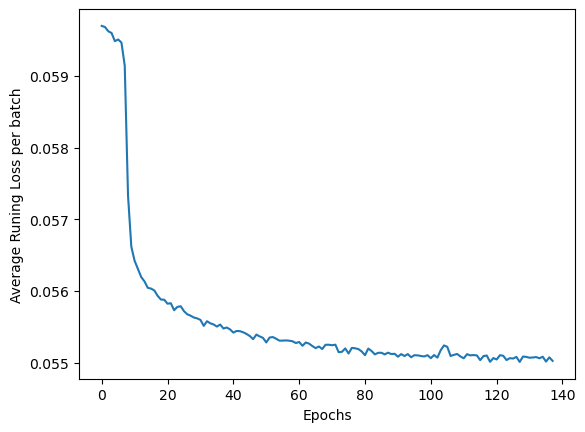

In [66]:
epoch_arr = np.arange(0, len(avg_loss_list))
loss_arr = np.array(avg_loss_list)
plt.plot(avg_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

In [67]:
torch.save(final_model, 'model_100206_13g_05.pt')